### Goals: 

1. To test out the CL3bReader class
2. 
    a. To plot distributions of Rrs_unc from a global l3b data file, by regions
    
    b. To add 95% hdi shade to each histogram
    
3. To plot summary data similarly to PACE unc summary graphs, with the 95%hdi shade added.

In [1]:
from auxiliary import GetHDI, PlotDist, GetDistrib
from obpgpyutils.LxReader.readers import CL3bReader
from matplotlib.pylab import rcParams
import matplotlib.pyplot as pl
import os
import pandas as pd
import numpy as np
import seaborn as sb

In [2]:
rcParams['xtick.labelsize']=16
rcParams['ytick.labelsize']=16
% matplotlib inline

In [3]:
# DATA STUFF
dataDir = '/accounts/ekarakoy/disk02/UNCERTAINTIES/Monte-Carlo/SWF/DATA/L2_L3/GLOBAL/StandardRun/'
fname = 'S20031932003196.L3b_4D_SU4.nc'
fp = os.path.join(dataDir,fname)

In [5]:
bands = ['412','443','490','510','555','670']
prodlist = ['Rrs_unc_%s' % band for band in bands ]
regions ='all'

In [6]:
myl3 = CL3bReader(fp, prodlist, regions='all')

In [7]:
myl3.regionMaskDict.keys()

dict_keys(['meso', 'olig', 'eutr', 'deep'])

In [8]:
bands=['412','443','490','510','555','670']
regKeys = ['all','eutr','olig','meso','deep']
wtdMeanDict = dict.fromkeys(regKeys)
hdiLoDict = dict.fromkeys(regKeys)
hdiHiDict = dict.fromkeys(regKeys)
for reg in regKeys:
    wtdMeanDict[reg] = dict.fromkeys(bands)
    hdiLoDict[reg] = dict.fromkeys(bands)
    hdiHiDict[reg] = dict.fromkeys(bands)

In [9]:
# Fill the Dictionaries I'll use for plotting
alpha = 0.95
for reg in regKeys:
    for band in bands:
        distDict = {}
        hdiDict = {}
        if reg == 'all': 
            tempArr = myl3.productDict['Rrs_unc_%s' % band]
        else:
            tempArr = myl3.productDict['Rrs_unc_%s' % band][myl3.regionMaskDict[reg]]
        # Get distribution parameters
        distDict = GetDistrib(tempArr)
        cnt, wid, cen = distDict['counts'], distDict['widths'], distDict['centers']
        # getHDI
        hdiDict = GetHDI(cnt, binWidth=wid,credMass=alpha)
        wtdCounts = cnt * wid
        hdiLims=cen[hdiDict['hdiIndices'].min()],cen[hdiDict['hdiIndices'].max()]
        wtdMeanDict[reg][band] = np.sum(wtdCounts*cen/wtdCounts.sum())
        hdiLoDict[reg][band],hdiHiDict[reg][band] = min(hdiLims),max(hdiLims)

In [10]:
# Convert Dictionaries to PANDAS DataFrames:
wmdf = pd.DataFrame(wtdMeanDict)
hdiLodf = pd.DataFrame(hdiLoDict)
hdiHidf = pd.DataFrame(hdiHiDict)

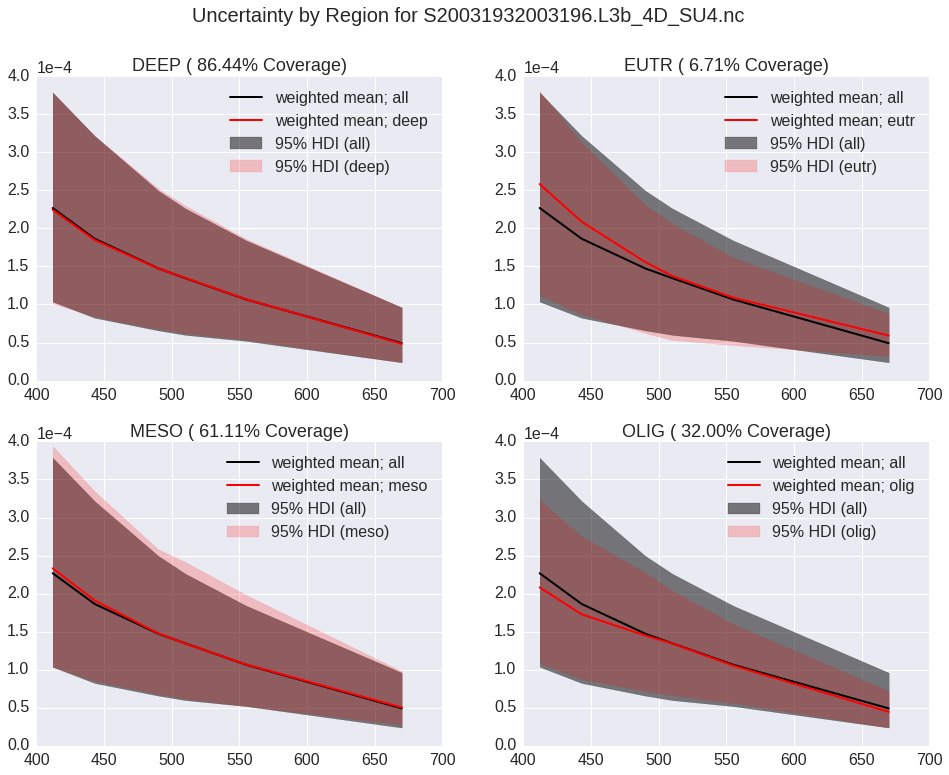

In [16]:
f,axs = pl.subplots(nrows=2,ncols=2,figsize=(16,12))
bandnum = [int(band) for band in bands]
# Compare 'all', with each other masking
regs = ['deep','eutr','meso','olig']
f.suptitle('Uncertainty by Region for %s' %fname,fontsize=20)
for ax,reg in zip (axs.ravel(),regs):
    percCov = myl3.regionMaskDict[reg].sum()/myl3.regionMaskDict[reg].size * 100
    ax.set_title('%s ( %.2f%% Coverage)' % (reg.upper(), percCov), fontsize=18)
    means = np.array(wmdf.loc[bands,'all'])
    hiy = np.array(hdiHidf.loc[bands,'all'])
    loy = np.array(hdiLodf.loc[bands,'all'])
    ax.plot(bands,wmdf.loc[bands,'all'],'k',lw=2,label='weighted mean; all')
    ax.plot(bands,wmdf.loc[bands,reg],'red',lw=2,label='weighted mean; %s' %reg)
    ax.fill_between(bandnum,y1=hdiHidf.loc[bands,'all'],
                    y2=hdiLodf.loc[bands,'all'],color='k',alpha=0.5,
                    label='95% HDI (all)')
    ax.fill_between(bandnum,y1=hdiHidf.loc[bands,reg],
                    y2=hdiLodf.loc[bands,reg],color='red',alpha=0.2,
                    label='95%% HDI (%s)' % reg)
    ax.ticklabel_format(style='sci',scilimits=(-2,3),axis='y')
    ax.legend(loc='best',fontsize=16)
f.savefig('UncertaintyByRegion_Global_%s.png' % fname,format='png')

In [19]:
msksum = 0
for reg in regs:
    msksum += myl3.regionMaskDict[reg].sum()
    print(reg, myl3.regionMaskDict[reg].sum(),myl3.regionMaskDict[reg].size)
print('total: %d, %d' % (msksum,myl3.regionMaskDict[reg].size))

deep 938473 1085676
eutr 72826 1085676
meso 663451 1085676
olig 347391 1085676
total: 2022141, 1085676
